In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [197]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [199]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data.csv'),
                    index_col=0)
#merged.index = merged.index.str.rstrip('-12345')
#mean_df = merged.groupby('ID').mean()
# Get rid of cold work
#cw_regex = re.compile("[0-9]+$") 
#mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
#mean_df.index = mean_df.index.str.rstrip('02468')
#mean_df.index = mean_df.index.str.rstrip('-')
merged.set_index('type_cw', inplace=True)
merged

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,
A286-0,79.177783,0.009250,-1.105716,0.002122,3.389241e+02,263.737111,11.109955,A286
A286-80,61.591571,1.999020,-1.315461,0.002242,3.430339e+02,216.858203,-55.754817,A286
347-20,145.570410,2.042111,-1.067350,0.001798,5.331034e+02,149.130079,-34.498156,347
304-40,101.067072,0.016699,-1.462649,0.002260,6.095010e+00,12.327287,-27.993260,304
A286-0,101.543576,0.320440,-1.270049,0.002692,1.182694e-02,101.160691,-9.956184,A286
...,...,...,...,...,...,...,...,...
347-20,126.193410,4.119353,-1.613274,0.002056,7.031386e+01,192.049968,5.342775,347
A286-60,30.773574,0.009250,-1.495208,0.002422,4.941366e+02,476.006445,-25.253517,A286
A286-0,101.023432,0.009250,-1.434419,0.002238,3.433636e+02,40.400294,-15.358474,A286


In [207]:
merged=merged[merged.index.isin(['304-0','304-20','304-40','304-60','304-80'])]

In [208]:
merged

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,
304-40,101.067072,0.016699,-1.462649,0.002260,6.095010e+00,12.327287,-27.993260,304
304-80,76.558688,3.048213,-1.012779,0.002543,4.131564e+01,142.762149,29.999999,304
304-0,83.215271,0.497963,-1.326228,0.002604,1.085048e+02,151.980761,3.687680,304
304-80,74.709257,4.233064,-1.024075,0.002213,1.044970e+02,218.270746,-56.900449,304
304-80,73.357998,4.088480,-0.967967,0.002704,1.202178e+02,144.003215,-29.161505,304
...,...,...,...,...,...,...,...,...
304-40,81.085123,0.408752,-1.439107,0.002011,8.568951e+01,96.774923,-14.482325,304
304-60,149.744029,3.137834,-1.145481,0.002648,2.247027e+01,138.205741,-2.786071,304
304-60,96.054456,2.682006,-1.411720,0.002624,3.305262e-03,169.668908,-6.131446,304


## Select columns of interest

In [93]:
#mean_df = mean_df[mc.regression_cols].dropna()

In [94]:
#mean_df.index=mean_df.index+"-"+mean_df.cold_work.astype("str")

In [209]:
#mean_df.drop(["cold_work"], axis=1, inplace=True)
merged.drop(["Type"], axis=1, inplace=True)

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [96]:
#mean_df=mean_df.iloc[10:15]
#mean_df

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,198.50,0.0220,-1.43700,0.002710,0.0,0.0,0.0
347-20,124.06,0.3400,-1.36400,0.001770,195.0,202.0,-25.0
347-40,89.88,1.0115,-1.27925,0.002237,182.0,241.0,-28.0
347-60,77.80,3.1390,-1.10000,0.002429,206.0,287.0,-33.0
347-80,74.00,6.3910,-0.82200,0.002559,206.0,255.0,-39.0


## Scale data

In [210]:
scaled_df = mc.scale_general(merged, MinMaxScaler())
scaled_df[0]

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
type_cw,,,,,,,
304-40,0.108602,0.001167,0.344812,0.385889,1.113221e-02,0.109267,0.414205
304-80,0.063803,0.476196,0.777263,0.636892,7.546080e-02,0.210618,1.000000
304-0,0.075971,0.076580,0.475950,0.690970,1.981782e-01,0.217781,0.734217
304-80,0.060422,0.661858,0.766404,0.344119,1.908582e-01,0.269290,0.122211
304-80,0.057952,0.639202,0.820340,0.779596,2.195714e-01,0.211582,0.402404
...,...,...,...,...,...,...,...
304-40,0.072077,0.062601,0.367442,0.164316,1.565073e-01,0.174885,0.550680
304-60,0.197580,0.490239,0.649699,0.729259,4.104075e-02,0.207078,0.668825
304-60,0.099440,0.418812,0.393769,0.707919,6.036884e-06,0.231525,0.635033


<AxesSubplot:>

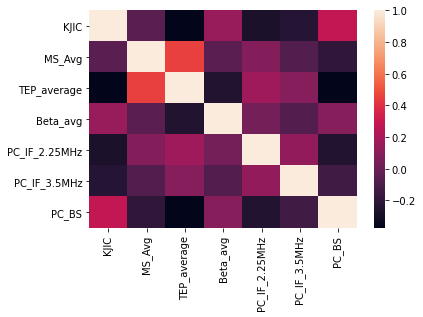

In [211]:
sns.heatmap(merged.corr())

In [212]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = scaled_df[0].drop('KJIC', axis = 1)
y = scaled_df[0]['KJIC']

In [148]:
X

,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
type_cw,,,,,,
A286-0,0.000000e+00,0.713210,0.360537,2.524908e-01,0.205757,0.809191
A286-80,3.117906e-01,0.538453,0.447521,2.555525e-01,0.181152,0.133790
347-20,3.185429e-01,0.745176,0.125590,3.971500e-01,0.145606,0.348503
304-40,1.167180e-03,0.415817,0.461160,4.540645e-03,0.073805,0.414209
A286-0,4.876241e-02,0.576290,0.774624,8.810806e-06,0.120429,0.596402
...,...,...,...,...,...,...
347-20,6.440401e-01,0.290317,0.312579,5.238224e-02,0.168132,0.750937
A286-60,1.059711e-08,0.388689,0.578521,3.681206e-01,0.317165,0.441884
A286-0,2.359452e-13,0.439338,0.444964,2.557981e-01,0.088539,0.541834


In [213]:
from sklearn.model_selection import train_test_split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(184,)
(79, 6)


## Linear Regression

In [215]:
from sklearn.linear_model import LinearRegression

In [216]:
lr = LinearRegression()

In [217]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [218]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

0.19585073227937927


,Coefficient
MS_Avg,0.065977
TEP_average,-0.201107
Beta_avg,0.043051
PC_IF_2.25MHz,-0.145857
PC_IF_3.5MHz,-0.091477
PC_BS,0.065939


In [155]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

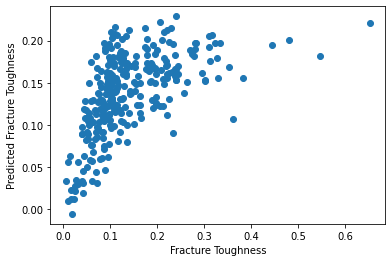

In [156]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [157]:
from sklearn import metrics

In [158]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.051464254311065126
MSE: 0.005229923648100843
RMSE: 0.07231821104051761


## Lasso

In [159]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [160]:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)

Lasso Regression: R^2 score on training set 0.0
Lasso Regression: R^2 score on test set -0.18780498792629885


In [161]:
# Lasso with different lambdas
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [162]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

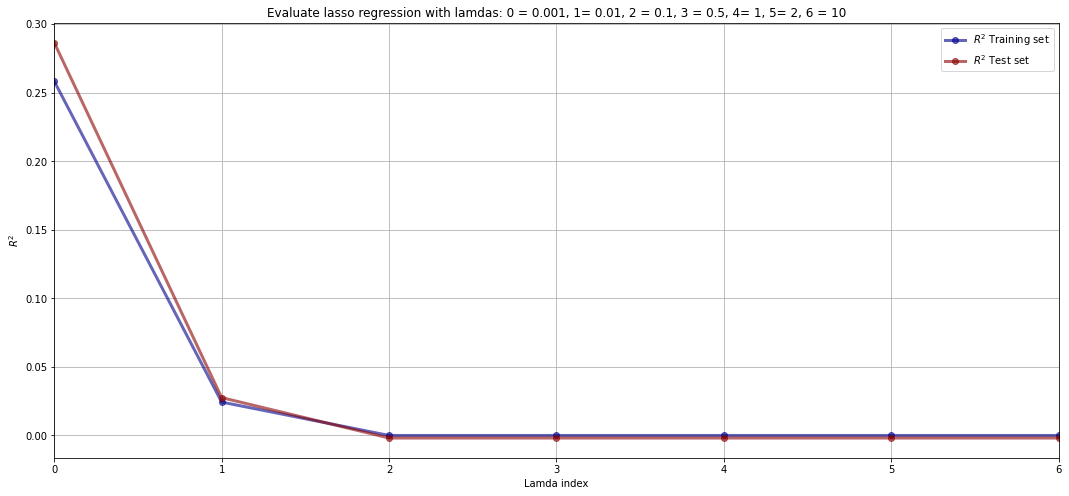

In [163]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [164]:
# Identifying the best lambda
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    28.646931
lambda        0.001000
Name: 0, dtype: float64

In [165]:
# Coefficients of best model
reg_best = Lasso(alpha = 0.001)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([ 0.00640889, -0.        , -0.        , -0.06707773, -0.06417356,
        0.09880476])

In [166]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

0.005462436465855287

In [167]:
# Cross Validation
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [168]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2") 

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

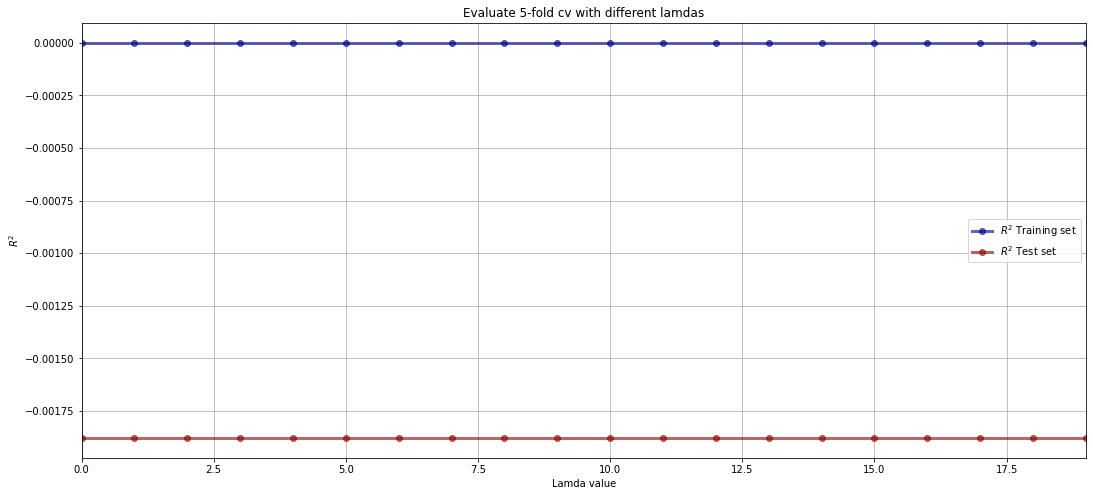

In [169]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [170]:
# Best Model
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared   -0.187805
lambda       0.050000
Name: 0, dtype: float64

In [171]:
# Best Model
reg_best = Lasso(alpha = 0.05)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [172]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))

0.0076698806432316325

In [173]:
reg_best.coef_

array([ 0., -0.,  0., -0., -0.,  0.])

Text(0, 0.5, 'Predicted Fracture Toughness')

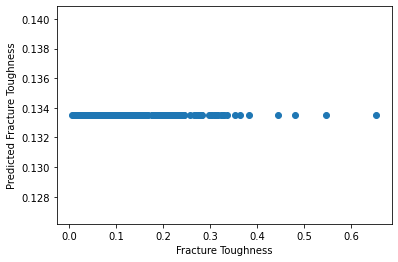

In [174]:
pred1 = reg_best.predict(X_test)
plt.scatter(y_test,pred1)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [175]:
pred1

array([0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351077,
       0.13351077, 0.13351077, 0.13351077, 0.13351077, 0.13351

## Ridge Regression

In [176]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.07988422309029111
0.271276243582526
0.07231954538682311
0.31681608767740066


Text(0, 0.5, 'Predicted Fracture Toughness')

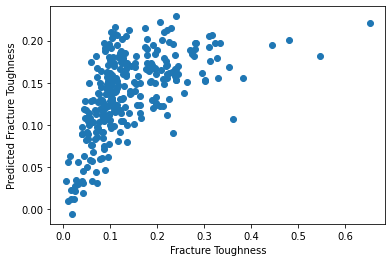

In [177]:
plt.scatter(y_test,pred_test_rr)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Elastic net

In [178]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.08579658892099314
0.15941634818044703
0.07899131034687706
0.18494879750516202


Text(0, 0.5, 'Predicted Fracture Toughness')

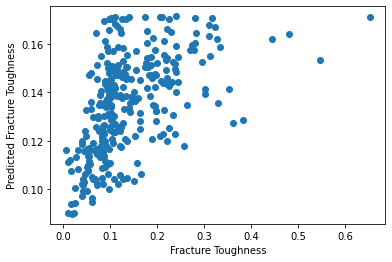

In [179]:
plt.scatter(y_test,pred_test_enet)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")